<style>
div.cell { /* Tunes the space between cells */
margin-top:0em;
margin-bottom:0em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Calibri';
color: #151B54;
font-weight: normal;
font-size:1.2em;
line-height:1.1em;
padding-left:3em;
padding-right:3em;
}

h1 {
text-align:center;
font-family:"Trebuchet MS", serif;
color: #A52A2A;
}
h2 {
text-align:center;
font-family:"Trebuchet MS", serif;
color: #A52A2A;
}
h3 {
text-align:left;
font-family:"Trebuchet MS", serif;
color: #A52A2A;
}
h4 {
text-align:left;
font-family:"Trebuchet MS", serif;
color: #A52A2A
}
h5 {
text-align:left;
font-family:"Trebuchet MS", serif;
color: #A52A2A
}
div#notebook {
    background-color: #002b36;
}
</style>
## DATA 620 Assignment Week 2, Part 1  

<b>Stephen Jones</b>  
<b>Group 6: Alice Friedman, Stephen Jones, Jeffrey Littlejohn, Jun Pan</b>  
<b>June 9, 2019</b>  

###The Assignment

Our task is to load a graph database of our choice and then conduct a basic analysis on the graph. That anaylsis should include calculating the graph's diameter and at least one other metric of our choosing, using either built-in functions to an existing package or our own methodology. We are to use a visualization tool to display our data.

###Our Data: StackOverflow Math Questions & Answers

We are utilizing a dataset from MathOverflow, one of the many question and answer sites that spun off from the excellent programming focused StackOverflow site. This data is provided by Stanford University's SNAP program, which hosts a number of graph and network datasets.

From Stanford's documentation regarding the dataset:

This is a temporal network of interactions on the stack exchange web site Math Overflow. There are three different types of interactions represented by a directed edge (u, v, t):

user u answered user v's question at time t (in the graph sx-mathoverflow-a2q)<br>
user u commented on user v's question at time t (in the graph sx-mathoverflow-c2q)<br>
user u commented on user v's answer at time t (in the graph sx-mathoverflow-c2a)<br>

We will start with the "a2q" data, which includes answers to questions. MathOverflow allows users to pose math questions to a self-selected audience of experts and hobbyists. Its conventions allow users to answer questions, post "comments" on questions, or post comments on answers. For our first analysis, we will only look at answers and not comments. Many of the best and most insightful exchanges on the site happen in comments, so our later analysis will use data the combines answers, comments on questions, and comments on answers.

More details on our "a2q" answers dataset:

Dataset statistics (sx-mathoverflow-a2q)
Nodes 21688
Temporal Edges 107581
Edges in static graph 90489
Time span 2350 days

Let's translate this to English - this is more than 20,000 users (nodes) interacting with more than 100,000 questions during a time period of just fewer than seven years.

Both our "a2q" data and larger dataset that also includes comments constitute directional graphs - users are ANSWERING the questions of others or RESPONDING to questions or comments. The edges are indicative of a direction. A contrast would be relationships on Facebook - relationships on that site are undirected. Self-loops are possible in that a user can answer or comment on their own question.


### Import relevant packages

`matplotlib`, `numpy`, `neo4j`, `networkx`, `pandas` are loaded to the workspace. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

### Data import

Here, we read the "a2q" data as an edgelist and name it object "g". Each node represents a user (labeled with a user id), while each edge represents an answered question between two users.


# MathOverflow: Questions Answered

In [4]:
#load file using DiGraph for directional graph due to nature of data
g=nx.read_edgelist('sx-mathoverflow-a2q.txt', create_using=nx.DiGraph(), nodetype=int, data=(('weight',float),))

To preserve the edgelist with no alterations, we rename to G; next we obtain the number of nodes to limit the scope of our plot.

In [5]:
G=g

nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 21688\nNumber of edges: 90489\nAverage in degree:   4.1723\nAverage out degree:   4.1723'

Our nodes match the expected amount, and the number of edges matches the edges in the static graph as detailed by Stanford's metadata.

#### Subsetting the data  

There are more than 21K nodes, which would make visualization a fool's errand. We'll only keep nodes with more than 100 degrees, a subject we'll explain in a minute.

Reference: https://stackoverflow.com/questions/8576737/how-to-only-keep-nodes-in-networkx-graph-with-2-outgoing-edges-or-0-outgoing-ed

In [6]:
#remove nodes with 100 or fewer degrees
outdeg = G.out_degree()
to_remove = [n for (n,deg) in outdeg if outdeg[n] <= 100 ]

G.remove_nodes_from(to_remove)

View the resulting data.

In [7]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 183\nNumber of edges: 4122\nAverage in degree:  22.5246\nAverage out degree:  22.5246'

Our data is thus significantly limited, which will enable plotting.

#### Set node colors and size

The degree of a node is indicative of the number of connections it has to other nodes. Thus, from our a2q data, a node with a higher degree will have likely answered a wider variety of user's questions. We will obtain the size of node from degree and set color from degree to enable a more effective visualizaiton.

Reference: https://stackoverflow.com/questions/35782251/python-how-to-color-the-nodes-of-a-network-according-to-their-degree

In [8]:
degrees=G.degree()
nodes=G.nodes()

n_color=np.asarray([degrees[n] for n in nodes])

### Plot

Plot the network.

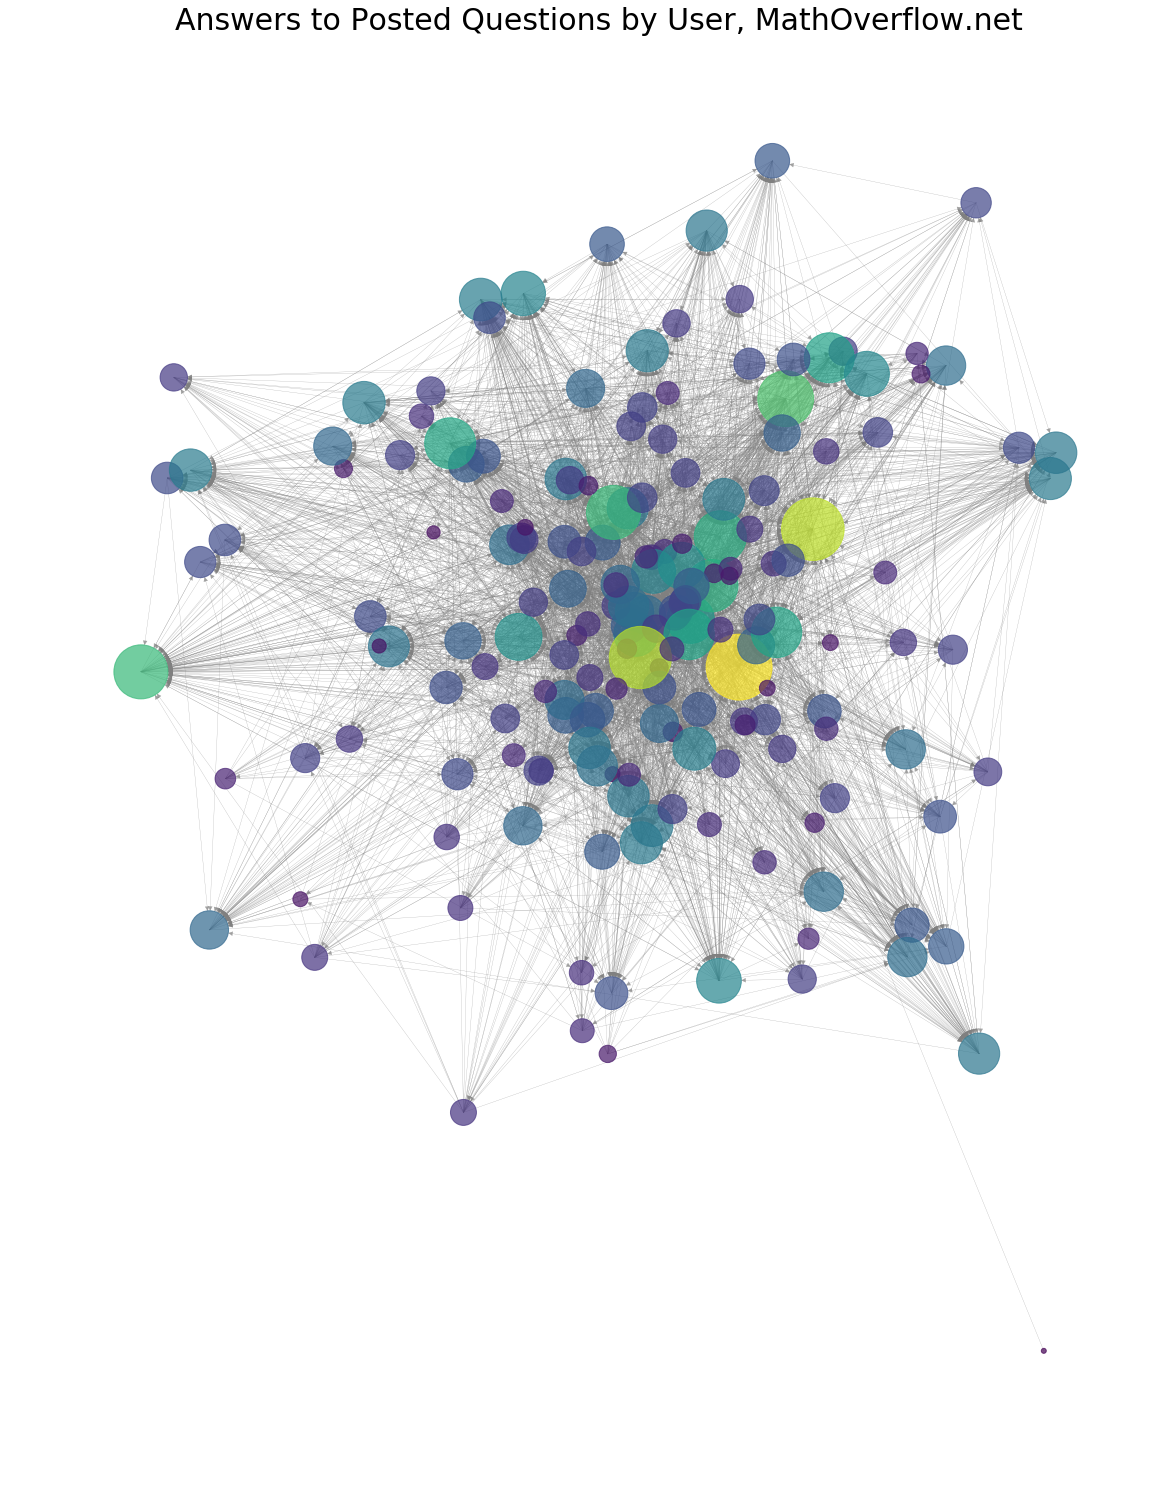

In [9]:
import warnings
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111,aspect = 'equal')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

nx.draw(G,
        node_color=n_color,
        with_labels = False, 
        node_size=n_color*25,
        edge_color='gray', 
        font_size=10,
        font_color='black',
        cmap='viridis',
        width=.25,
        alpha = .7)
plt.title('Answers to Posted Questions by User, MathOverflow.net',fontsize=30)
plt.show()


The larger yellow and aqua nodes have a higher degree.

Now, let's look at the MathOverflow dataset that includes answers and comments.

# MathOverflow: All Interactions

In [10]:
gu=nx.read_edgelist('sx-mathoverflow.txt', create_using=nx.DiGraph(), nodetype=int, data=(('weight',float),))

GU=gu

nx.info(GU)

'Name: \nType: DiGraph\nNumber of nodes: 24818\nNumber of edges: 239978\nAverage in degree:   9.6695\nAverage out degree:   9.6695'

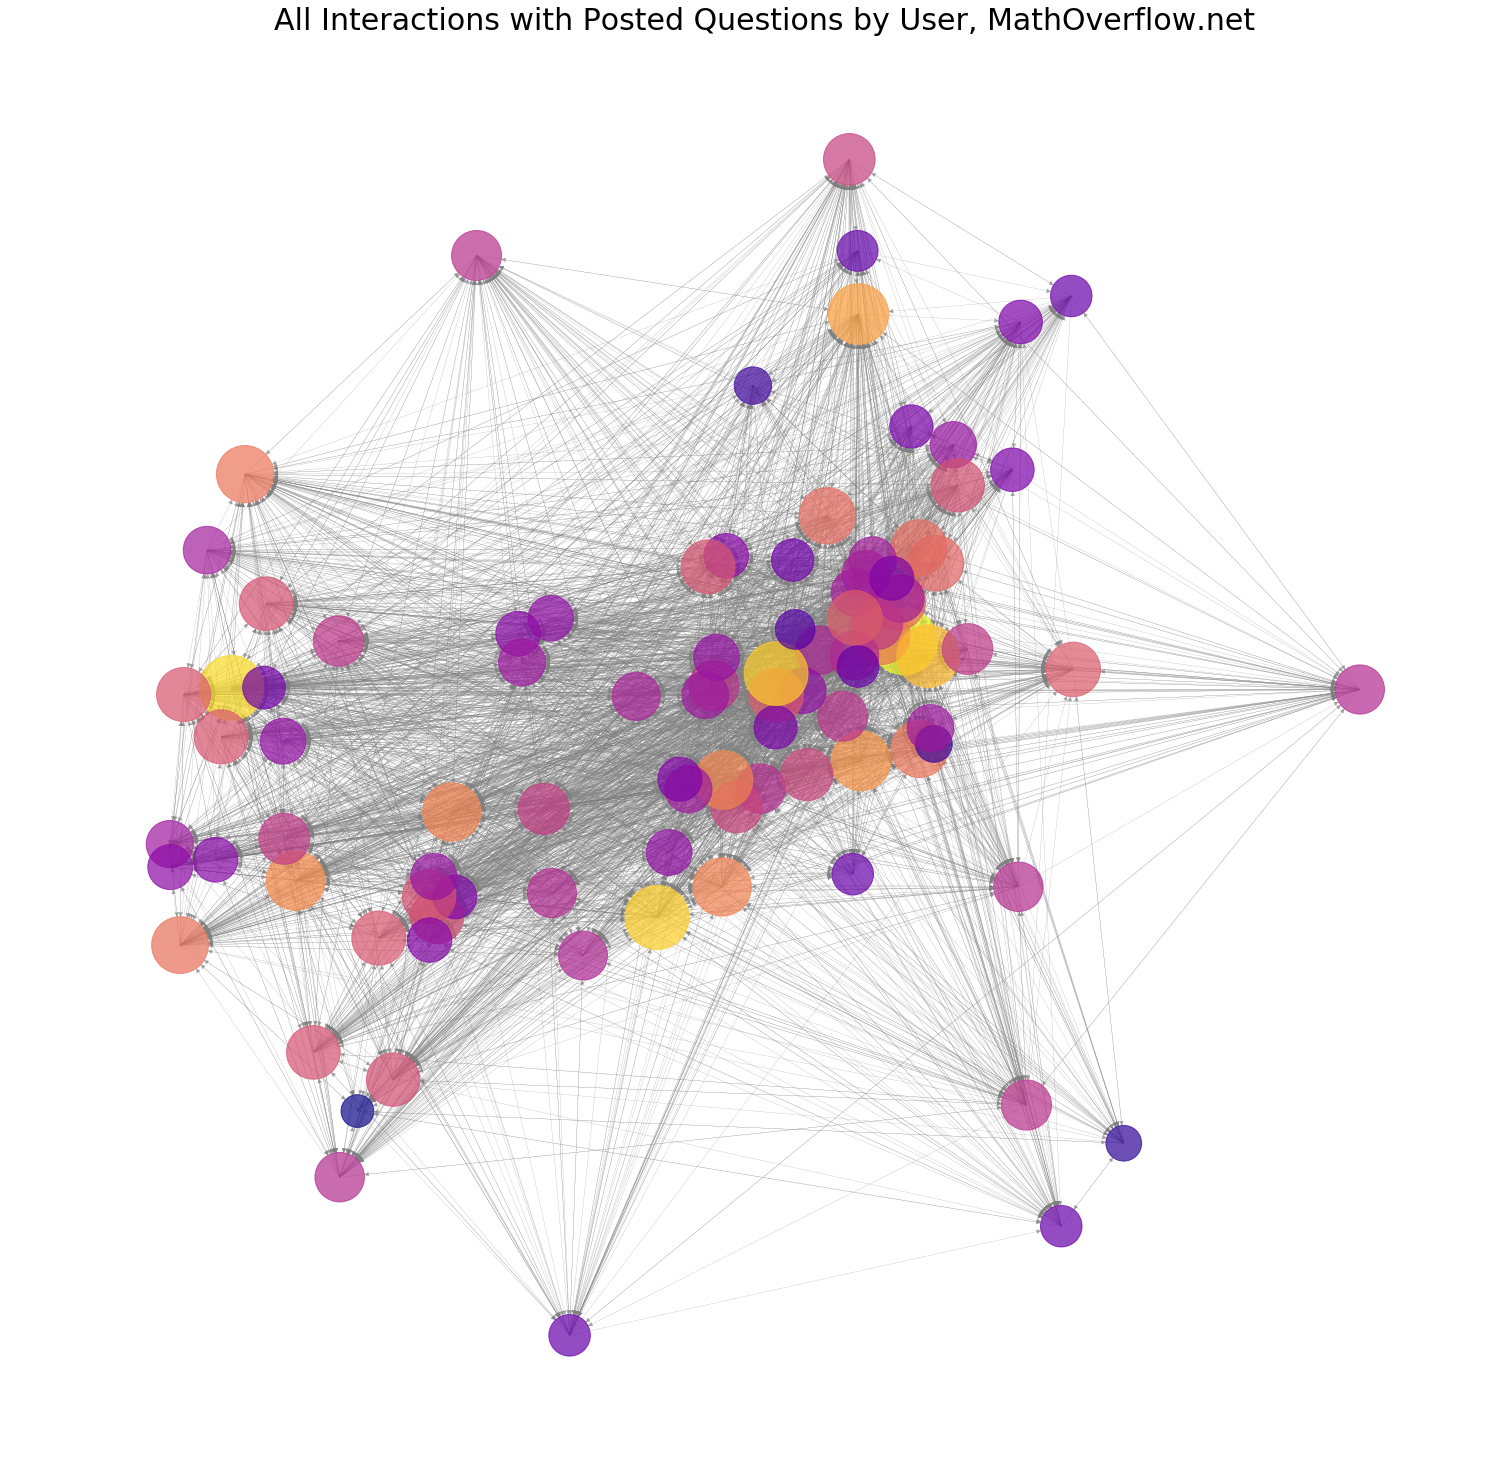

In [11]:
outdeg = GU.out_degree()
to_remove = [n for (n,deg) in outdeg if outdeg[n] <= 400 ]

GU.remove_nodes_from(to_remove)

degrees=GU.degree()
nodes=GU.nodes()

n_color=np.asarray([degrees[n] for n in nodes])

import warnings
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111,aspect = 'equal')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

nx.draw(GU,
        node_color=n_color,
        with_labels = False, 
        node_size=n_color*25,
        edge_color='gray', 
        font_size=10,
        font_color='black',
        cmap='plasma',
        width=.25,
        alpha = .7)
plt.title('All Interactions with Posted Questions by User, MathOverflow.net',fontsize=30)
plt.show()

Here, our yellow and orange larger nodes indicate higher degrees.

## Analysis

We will now look at diameter and other graph metrics using both the answer (dataset G) and combined answer and comments (dataset GU) datasets.

#### Diameter

`Diameter` is essentially a count of the number of edges in the shortest path between the most distant nodes. Think the quickest route between San Diego and Maine. Because of the nature of the graph of answers the diameter is effectively infinite as there is no path to the most distant nodes (every answer is a directed edge to another node).

Below we calculate the undirected diameter of the answer graph, as well as the diameter of the graph of all interactions.

Reference: https://stackoverflow.com/questions/33114746/why-does-networkx-say-my-directed-graph-is-disconnected-when-finding-diameter

In [12]:
#answer dataset
nx.diameter(G.to_undirected())

3

In [13]:
#combined answer and comments dataset
nx.diameter(GU)

2

#### Eccentricity

Shortest path from a node to all other nodes. We should note the diameter is actually the maximum eccentricity between two nodes in the dataset. Let's look at the answer and comments dataset.

In [14]:
nx.eccentricity(GU)

{1450: 2,
 45: 2,
 66: 2,
 75: 2,
 78: 2,
 297: 2,
 121: 2,
 290: 2,
 317: 2,
 353: 2,
 13265: 2,
 2926: 2,
 454: 2,
 763: 2,
 613: 2,
 766: 2,
 394: 2,
 1056: 2,
 1131: 2,
 1149: 2,
 1384: 2,
 1353: 2,
 1310: 2,
 1345: 2,
 1847: 2,
 1463: 2,
 1465: 2,
 1441: 2,
 1409: 2,
 4177: 2,
 1898: 2,
 391: 2,
 1946: 2,
 2290: 2,
 2384: 2,
 2530: 2,
 2554: 2,
 2841: 2,
 2000: 2,
 2874: 2,
 3324: 2,
 3106: 2,
 2954: 2,
 3206: 2,
 3272: 2,
 3402: 2,
 3684: 2,
 3948: 2,
 4144: 2,
 4231: 2,
 4721: 2,
 4832: 2,
 4961: 2,
 6794: 2,
 4312: 2,
 5740: 2,
 5690: 2,
 6094: 2,
 6085: 2,
 6101: 2,
 6666: 2,
 6976: 2,
 7206: 2,
 7460: 2,
 8008: 2,
 8212: 2,
 8799: 2,
 8103: 2,
 9072: 2,
 8430: 2,
 10076: 2,
 10400: 2,
 10503: 2,
 10366: 2,
 11054: 2,
 11142: 2,
 11260: 2,
 11919: 2,
 12166: 2,
 12705: 2,
 13650: 2,
 13972: 2,
 14094: 2,
 15629: 2,
 11540: 2,
 14450: 2,
 14830: 2,
 15934: 2,
 21684: 2,
 9025: 2,
 18060: 2,
 20302: 2,
 25510: 2,
 8385: 2,
 40297: 2}

#### General Descriptives

Here, we run a number of metrics to describe the answers dataset (G).

In [16]:
print('The mean count of incoming interactions for each node:', np.mean([G.in_degree(n) for n in G.nodes]))
print('The mean count of outgoing interactions for each node:', np.mean([G.out_degree(n) for n in G.nodes]))
print('The mean count of all interactions for each node:', np.mean([G.degree(n) for n in G.nodes]))
print('The count of all incoming interactions for every node:', np.sum([G.in_degree(n) for n in G.nodes]))
print('The count of all outgoing interactions for every node:', np.sum([G.out_degree(n) for n in G.nodes]))
print('The count of all interactions for every node:', np.sum([G.degree(n) for n in G.nodes]))
print('Lowest count of incoming interactions:', np.min([G.in_degree(n) for n in G.nodes]),' highest count:', np.max([G.in_degree(n) for n in G.nodes]))
print('Lowest count of outgoing interactions:', np.min([G.out_degree(n) for n in G.nodes]),' highest count:', np.max([G.out_degree(n) for n in G.nodes]))
print('Lowest count of all interactions:', np.min([G.degree(n) for n in G.nodes]),' highest count:', np.max([G.degree(n) for n in G.nodes]))


The mean count of incoming interactions for each node: 22.524590163934427
The mean count of outgoing interactions for each node: 22.524590163934427
The mean count of all interactions for each node: 45.049180327868854
The count of all incoming interactions for every node: 4122
The count of all outgoing interactions for every node: 4122
The count of all interactions for every node: 8244
Lowest count of incoming interactions: 0  highest count: 118
Lowest count of outgoing interactions: 1  highest count: 70
Lowest count of all interactions: 1  highest count: 174


In [17]:
print('The mean count of incoming interactions for each node:', np.mean([GU.in_degree(n) for n in GU.nodes]))
print('The mean count of outgoing interactions for each node:', np.mean([GU.out_degree(n) for n in GU.nodes]))
print('The mean count of all interactions for each node:', np.mean([GU.degree(n) for n in GU.nodes]))
print('The count of all incoming interactions for every node:', np.sum([GU.in_degree(n) for n in GU.nodes]))
print('The count of all outgoing interactions for every node:', np.sum([GU.out_degree(n) for n in GU.nodes]))
print('The count of all interactions for every node:', np.sum([GU.degree(n) for n in GU.nodes]))
print('Lowest count of incoming interactions:', np.min([GU.in_degree(n) for n in GU.nodes]),' highest count:', np.max([GU.in_degree(n) for n in GU.nodes]))
print('Lowest count of outgoing interactions:', np.min([GU.out_degree(n) for n in GU.nodes]),' highest count:', np.max([GU.out_degree(n) for n in GU.nodes]))
print('Lowest count of all interactions:', np.min([GU.degree(n) for n in GU.nodes]),' highest count:', np.max([GU.degree(n) for n in GU.nodes]))


The mean count of incoming interactions for each node: 50.33684210526316
The mean count of outgoing interactions for each node: 50.33684210526316
The mean count of all interactions for each node: 100.67368421052632
The count of all incoming interactions for every node: 4782
The count of all outgoing interactions for every node: 4782
The count of all interactions for every node: 9564
Lowest count of incoming interactions: 19  highest count: 90
Lowest count of outgoing interactions: 17  highest count: 88
Lowest count of all interactions: 43  highest count: 178


#### Density

Calculate the density of edges in the graph. Density is measure of the number of edges in a graph versus the number of possible edges. In a dense graph with a density near the theoretical maximum of 1, nodes would have edges between most other nodes. In the example of a social network, almost all users would be connected with almost all other users. In a sparse graph with a density near the theoretical minimum of 0, few nodes would have edges between them.

In [18]:
nx.density(G)

0.12376148441722212

#### Shortest Path Length, Average

Calculate the average of the shortest path length for all paths in the graph.

In [19]:
nx.average_shortest_path_length(G)

2.0323965651834506

#### Degree Connectivity, Average

For each node of given degree, what is the average degree of its neighbors?

In [20]:
nx.average_degree_connectivity(G)

{49: 40.69387755102041,
 72: 36.55555555555556,
 79: 25.234177215189874,
 59: 27.0,
 32: 45.05,
 91: 25.505494505494507,
 125: 36.816,
 58: 35.54597701149425,
 53: 37.405660377358494,
 68: 33.333333333333336,
 174: 24.5,
 35: 41.78095238095238,
 71: 30.793427230046948,
 31: 42.95161290322581,
 51: 34.73529411764706,
 23: 58.93478260869565,
 13: 59.97435897435897,
 34: 44.63865546218487,
 50: 37.45,
 61: 34.221311475409834,
 40: 39.69375,
 69: 30.170289855072465,
 117: 14.931623931623932,
 47: 26.27659574468085,
 54: 24.88888888888889,
 62: 29.241935483870968,
 45: 30.88888888888889,
 100: 30.46,
 21: 51.888888888888886,
 24: 55.13194444444444,
 46: 31.66304347826087,
 30: 48.50555555555555,
 63: 35.666666666666664,
 110: 23.345454545454544,
 77: 22.90909090909091,
 37: 34.414414414414416,
 88: 23.0,
 104: 28.08653846153846,
 55: 30.745454545454546,
 109: 31.155963302752294,
 70: 28.07857142857143,
 87: 24.03448275862069,
 39: 39.87179487179487,
 81: 44.4320987654321,
 43: 36.4976744186

### Centrality

Reference: 
https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html
https://stackoverflow.com/questions/50241195/networkx-degree-centrality

#### Betweenness

In [21]:
G_dict = dict(nx.betweenness_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("\n TOP 10, betweenness centrality:")

for i in range(10):
    print(ordered_G[i])


 TOP 10, betweenness centrality:
11142
290
6094
297
1149
1946
3106
1532
1441
18060


#### Degree

In [22]:
G_dict = dict(nx.degree_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("\n TOP 10, degree centrality, overall:")


for i in range(10):
    print(ordered_G[i])


 TOP 10, degree centrality, overall:
290
6094
11142
297
1459
2841
1532
1946
1409
3106


#### In-Degree

In [23]:
G_dict = dict(nx.in_degree_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("\n TOP 10, in degree centrality:")


for i in range(10):
    print(ordered_G[i])


 TOP 10, in degree centrality:
6094
290
1459
2841
11142
1532
8799
1409
3106
2051


#### Out-Degree

In [24]:
G_dict = dict(nx.out_degree_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("\n TOP 10, out degree centrality:")


for i in range(10):
    print(ordered_G[i])


 TOP 10, out degree centrality:
297
11142
290
454
2384
1946
1450
121
1149
3684


#### Eigenvector

In [25]:
G_dict = dict(nx.eigenvector_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("\n TOP 10, eigenvector centrality:")


for i in range(10):
    print(ordered_G[i])


 TOP 10, eigenvector centrality:
290
1459
6094
2841
1532
11142
3106
45
1587
2051


Citation for data:  

- Ashwin Paranjape, Austin R. Benson, and Jure Leskovec. "Motifs in Temporal Networks." In Proceedings of the Tenth ACM International Conference on Web Search and Data Mining, 2017.

###Conclusion

We looked at data from MathOverflow questions and comments. It would be interesting to add some metadata such as subject tags from the questions to conduct a more nuanced study of users 